In [ ]:
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import plot_importance


public_data = pd.read_csv('extracted_public_data.csv')
public_data = public_data.dropna()
mapping = {
    "precision": {"single": 0, "double": 1},
    "backend": {"GPU": 0, "CPU": 1}
}
remapped_public_data = public_data.replace(mapping)
remapped_public_data['normalized_threshold'] = (1/8) * np.log2(remapped_public_data['threshold'])

features = pd.read_csv('qasm_features_scaled.csv')

match_col_test = remapped_public_data.columns[0]
match_col_features = features.columns[0]

inputs = pd.merge(
    remapped_public_data, 
    features, 
    left_on=match_col_test, 
    right_on=match_col_features, 
    how='left'
)
inputs = inputs.drop(columns=[match_col_features])



y = np.log(public_data['expected_runtime_sec'])
inputs = inputs.drop(columns=['circuit', "threshold", 'fidelity', 'expected_runtime_sec'])

inputs.to_csv('inputs.csv', index=False)



C:\Users\percy\AppData\Local\Temp\ipykernel_37796\993031784.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  remapped_public_data = public_data.replace(mapping)


In [53]:
x_train, x_test, y_train, y_test = train_test_split(inputs, y, test_size=0.2, random_state=42)
eval_set = [(x_train, y_train), (x_test, y_test)]


xgb_model = xgb.XGBRegressor(objective="reg:squarederror", eval_metric=["rmse"], 
    eval_set=eval_set,  random_state=42)

In [57]:
xgb_model.fit(
    x_train, 
    y_train, 
    eval_set=eval_set,
    verbose=True  # This ensures the output is printed per iteration
)

[0]	validation_0-rmse:1.66301	validation_1-rmse:1.80624
[1]	validation_0-rmse:1.24264	validation_1-rmse:1.37780
[2]	validation_0-rmse:0.93703	validation_1-rmse:1.05399
[3]	validation_0-rmse:0.72071	validation_1-rmse:0.84040
[4]	validation_0-rmse:0.56391	validation_1-rmse:0.67794
[5]	validation_0-rmse:0.45409	validation_1-rmse:0.56990
[6]	validation_0-rmse:0.36869	validation_1-rmse:0.49183
[7]	validation_0-rmse:0.30861	validation_1-rmse:0.43025
[8]	validation_0-rmse:0.25865	validation_1-rmse:0.39388
[9]	validation_0-rmse:0.22504	validation_1-rmse:0.37274
[10]	validation_0-rmse:0.19648	validation_1-rmse:0.35192
[11]	validation_0-rmse:0.17670	validation_1-rmse:0.33835
[12]	validation_0-rmse:0.15610	validation_1-rmse:0.33185
[13]	validation_0-rmse:0.14101	validation_1-rmse:0.32616
[14]	validation_0-rmse:0.12807	validation_1-rmse:0.32145
[15]	validation_0-rmse:0.11896	validation_1-rmse:0.31856
[16]	validation_0-rmse:0.10873	validation_1-rmse:0.31458
[17]	validation_0-rmse:0.10202	validation

c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:12:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "eval_set" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,['rmse']


In [55]:
y_pred = xgb_model.predict(x_test)

In [46]:
mse=mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.09070790917128828


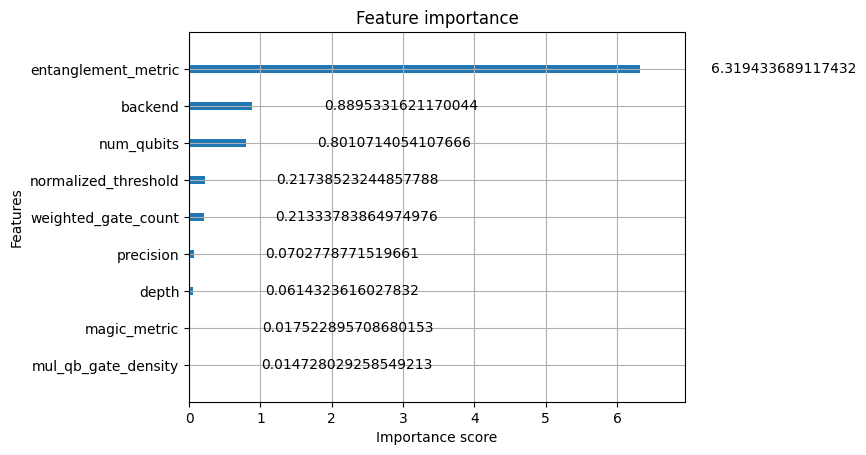

In [47]:
plot_importance(xgb_model, importance_type='gain')
plt.show()

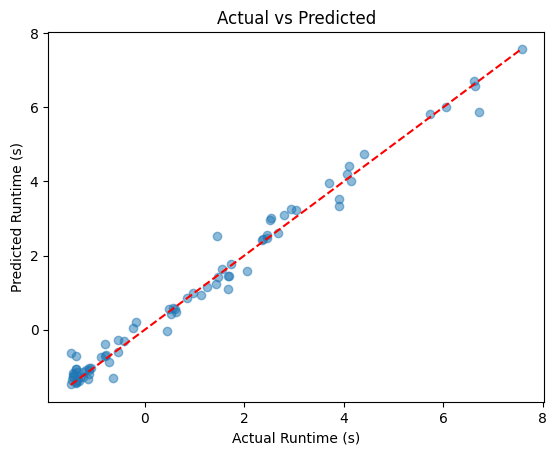

In [35]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Runtime (s)')
plt.ylabel('Predicted Runtime (s)')
plt.title('Actual vs Predicted')
plt.show()

In [ ]:
xgb_model.save_model("runtime_xgboost.json")

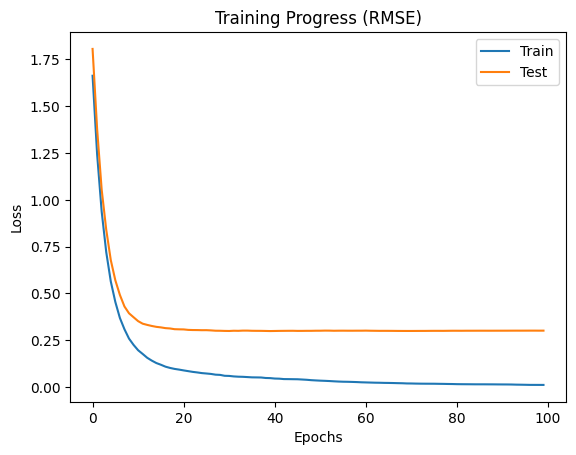

In [59]:
# Retrieve and plot the training logs
results = xgb_model.evals_result()

plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.title('Training Progress (RMSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
